In [1]:
# TensorFlow Hubで訓練済みモデルを共有することができる

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
!pip install -q -U tf-hub-nightly
import tensorflow_hub as hub

from tensorflow.keras import layers

     |████████████████████████████████| 112kB 27.7MB/s 


In [4]:
# MobileNetV2をTFHubからダウンロードして利用してみよう
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

In [16]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE + (3, ))    
])

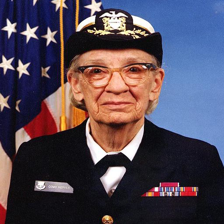

In [17]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [18]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [19]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [20]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [21]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


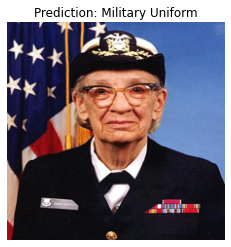

In [22]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [23]:
# MobileNetV2を使った転移学習 w/ tensorflow hub

In [24]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228818944/228813984 [==============================] - 1s 0us/step


In [25]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [26]:
for image_batch, label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [27]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [28]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['rapeseed', 'daisy', 'butcher shop', 'stinkhorn', 'artichoke',
       'daisy', 'daisy', 'rapeseed', 'bee', 'pitcher', 'greenhouse',
       'daisy', 'daisy', 'daisy', 'restaurant', 'tick', 'daisy', 'daisy',
       'vase', 'sea urchin', 'pot', 'pot', 'pot', 'bonnet', 'ringlet',
       'dining table', 'daisy', 'daisy', 'maze', 'daisy', 'coral fungus',
       'artichoke'], dtype='<U30')

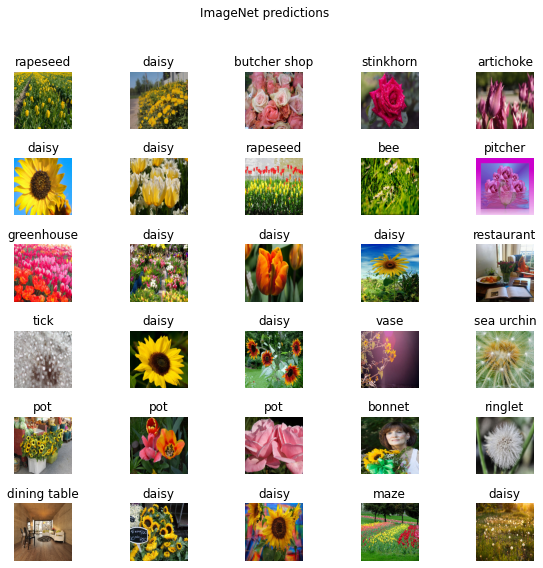

In [29]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [30]:
# 全然合ってない，けどそれはそう．ダウンロードしたモデルをそのまま使っているから．

In [31]:
# tf hubでは最上位層を外したモデルも配布している
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [32]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [33]:
feature_extractor_layer.trainable = False

In [34]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [35]:
predictions = model(image_batch)
predictions.shape

TensorShape([32, 5])

In [36]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [37]:
# custom callback
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=30,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
115/115 [==============================] - 16s 115ms/step - loss: 0.4641 - acc: 0.8125
Epoch 2/30
115/115 [==============================] - 13s 110ms/step - loss: 0.4631 - acc: 0.8438
Epoch 3/30
115/115 [==============================] - 13s 111ms/step - loss: 0.1543 - acc: 0.9688
Epoch 4/30
115/115 [==============================] - 13s 112ms/step - loss: 0.0440 - acc: 1.0000
Epoch 5/30
115/115 [==============================] - 13s 112ms/step - loss: 0.0972 - acc: 0.9688
Epoch 6/30
115/115 [==============================] - 13s 112ms/step - loss: 0.0984 - acc: 0.9688
Epoch 7/30
115/115 [==============================] - 13s 112ms/step - loss: 0.1037 - acc: 0.9688
Epoch 8/30
115/115 [==============================] - 13s 112ms/step - loss: 0.1770 - acc: 0.9688
Epoch 9/30
115/115 [==============================] - 13s 111ms/step - loss: 0.1198 - acc: 0.9688
Epoch 10/30
115/115 [==============================] - 13s 111ms/step - loss: 0.0655 - acc: 1.0000
Epoch 11/30
115/115

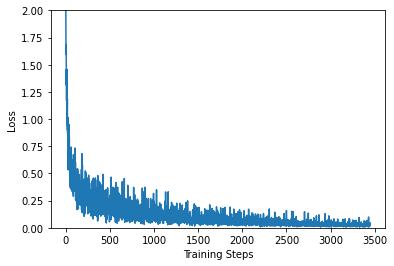

In [38]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

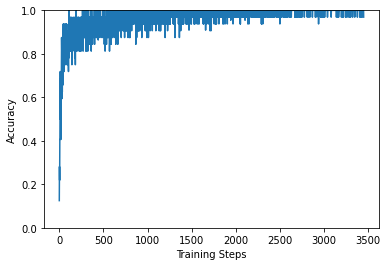

In [39]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [40]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [41]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

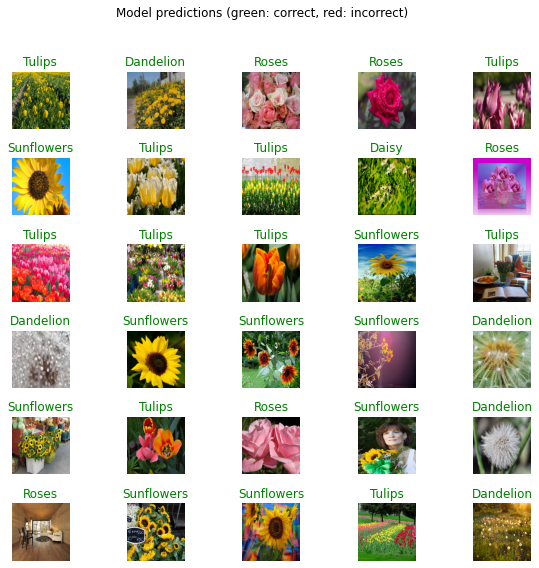

In [42]:
label_id = np.argmax(label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(predicted_label_batch[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [43]:
# 学習済みモデルは保存しておける
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1624852580/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1624852580/assets


'/tmp/saved_models/1624852580'

In [44]:
reloaded = tf.keras.models.load_model(export_path)

result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

abs(reloaded_result_batch - result_batch).max()

0.0